# Telecom X – Parte 2: Predicción de Cancelación (Churn)

Este notebook está **dividido en 4 secciones** para seguir el flujo solicitado:
1) **Preparación de datos** (carga CSV tratado, limpieza defensiva, one-hot si hace falta, split y desbalance)  
2) **Correlación y selección de variables** (matriz de correlación, top variables, mutual information)  
3) **Modelos predictivos** (Regresión Logística *con* normalización y Random Forest *sin* normalización; métricas y matrices de confusión)  
4) **Interpretación y conclusiones** (coeficientes LR, importancias RF, permutación opcional, resumen estratégico)


In [1]:
# === Tema global en escala de grises ===
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

PALETA = 'Greys'  
cmap = mpl.colormaps.get_cmap(PALETA)
COLORS = cmap(np.linspace(0.15, 0.85, 8))  

mpl.rcParams.update({
    'figure.figsize': (9, 6),
    'figure.dpi': 110,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.titleweight': 'bold',
    'axes.prop_cycle': cycler(color=[mpl.colors.to_hex(c) for c in COLORS]),
    'image.cmap': PALETA,                 
    'figure.constrained_layout.use': True 
})

# === Helpers de visualización ===
def _wrap_labels(labels, width=22):
    import textwrap
    return [textwrap.fill(str(x), width=width) for x in labels]

def _autosize(n_items, base=(9,6), step=0.35, limit=(22,16)):
    w = min(limit[0], max(base[0], base[0] + step*(n_items-10)))
    h = min(limit[1], max(base[1], base[1] + step*(n_items-10)))
    return (w, h)

def outline_bars(ax, lw=0.6, color='black'):
    """Aplica contorno fino a todas las barras del eje dado."""
    for p in ax.patches:
        p.set_edgecolor(color)
        p.set_linewidth(lw)


## 1) Preparación de datos


✔️ Cargado: telecomx_ml_ready_numeric.csv  shape=(7256, 32)
X shape: (7256, 31) | y shape: (7256,)

=== Distribución de clases ===
Activos (0): 5387 (74.24%)
Churn (1):  1869 (25.76%)


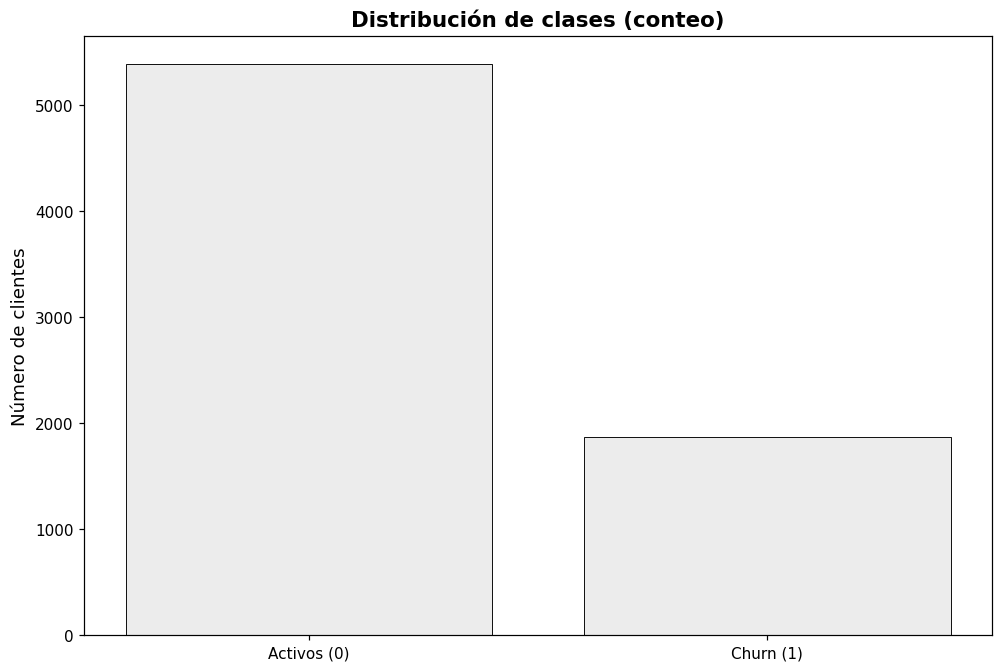

In [2]:
# === PREPARACIÓN DE DATOS (cargar, limpiar, one-hot) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_object_dtype  # OK
# ¡NO usar is_categorical_dtype (deprecado)!

# 1) Cargar CSV tratado (Parte 1)
CANDIDATES = ["telecomx_ml_ready_numeric.csv", "telecomx_ml_ready.csv", "telecomx_model_ready.csv"]
df = None
for path in CANDIDATES:
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"✔️ Cargado: {path}  shape={df.shape}")
        break
if df is None:
    raise FileNotFoundError("No se encontró un CSV tratado. Asegúrate de tener uno de: " + ", ".join(CANDIDATES))

# 2) Asegurar objetivo binario 0/1
if 'abandono' not in df.columns:
    raise ValueError("No se encontró la columna 'abandono' en el CSV.")

if not set(pd.unique(df['abandono'])).issubset({0, 1}):
    df['abandono'] = (df['abandono']
                      .astype('string').str.strip().str.lower()
                      .map({'yes': 1, 'no': 0})
                      .astype('int8'))

# 3) Quitar identificadores únicos si existen
for c in ['id_cliente', 'customerID']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# 4) Detectar columnas categóricas de forma compatible (SIN deprecations)
cat_cols = [
    c for c in df.columns
    if c != 'abandono' and (
        is_object_dtype(df[c]) or isinstance(df[c].dtype, pd.CategoricalDtype)
    )
]

# 5) One-Hot Encoding (drop_first para evitar colinealidad)
if cat_cols:
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='int8')

# 6) Separar X e y (todo numérico)
y = df['abandono'].astype('int8')
X = df.drop(columns=['abandono'])

# 7) Chequeos rápidos
assert not X.isna().any().any(), "Hay NaNs en X."
assert set(pd.unique(y)).issubset({0, 1}), "La variable objetivo debe ser 0/1."

print("X shape:", X.shape, "| y shape:", y.shape)

# 8) Vista rápida del balance de clases
counts = y.value_counts().sort_index()
props  = y.value_counts(normalize=True).sort_index()
print("\n=== Distribución de clases ===")
print(f"Activos (0): {counts.get(0,0)} ({props.get(0,0)*100:.2f}%)")
print(f"Churn (1):  {counts.get(1,0)} ({props.get(1,0)*100:.2f}%)")

plt.figure()
bars = plt.bar(['Activos (0)', 'Churn (1)'], [counts.get(0,0), counts.get(1,0)])
for b in bars:
    b.set_edgecolor('black'); b.set_linewidth(0.6)  
plt.title('Distribución de clases (conteo)')
plt.ylabel('Número de clientes')
plt.show()


## 2) Correlación y selección de variables


Top 20 |correlación| con 'abandono':


meses_en_empresa                              0.345799
tipo_internet_Fiber optic                     0.300416
tipo_contrato_Two year                        0.294467
metodo_pago_Electronic check                  0.294181
respaldo_online_No internet service           0.223755
seguridad_online_No internet service          0.223755
tipo_internet_No                              0.223755
proteccion_dispositivo_No internet service    0.223755
soporte_tecnico_No internet service           0.223755
peliculas_streaming_No internet service       0.223755
tv_streaming_No internet service              0.223755
cargos_totales                                0.194440
cuentas_diarias                               0.189393
cargos_mensuales                              0.189393
factura_electronica                           0.186309
tipo_contrato_One year                        0.174340
seguridad_online_Yes                          0.166865
soporte_tecnico_Yes                           0.160476
tiene_depe

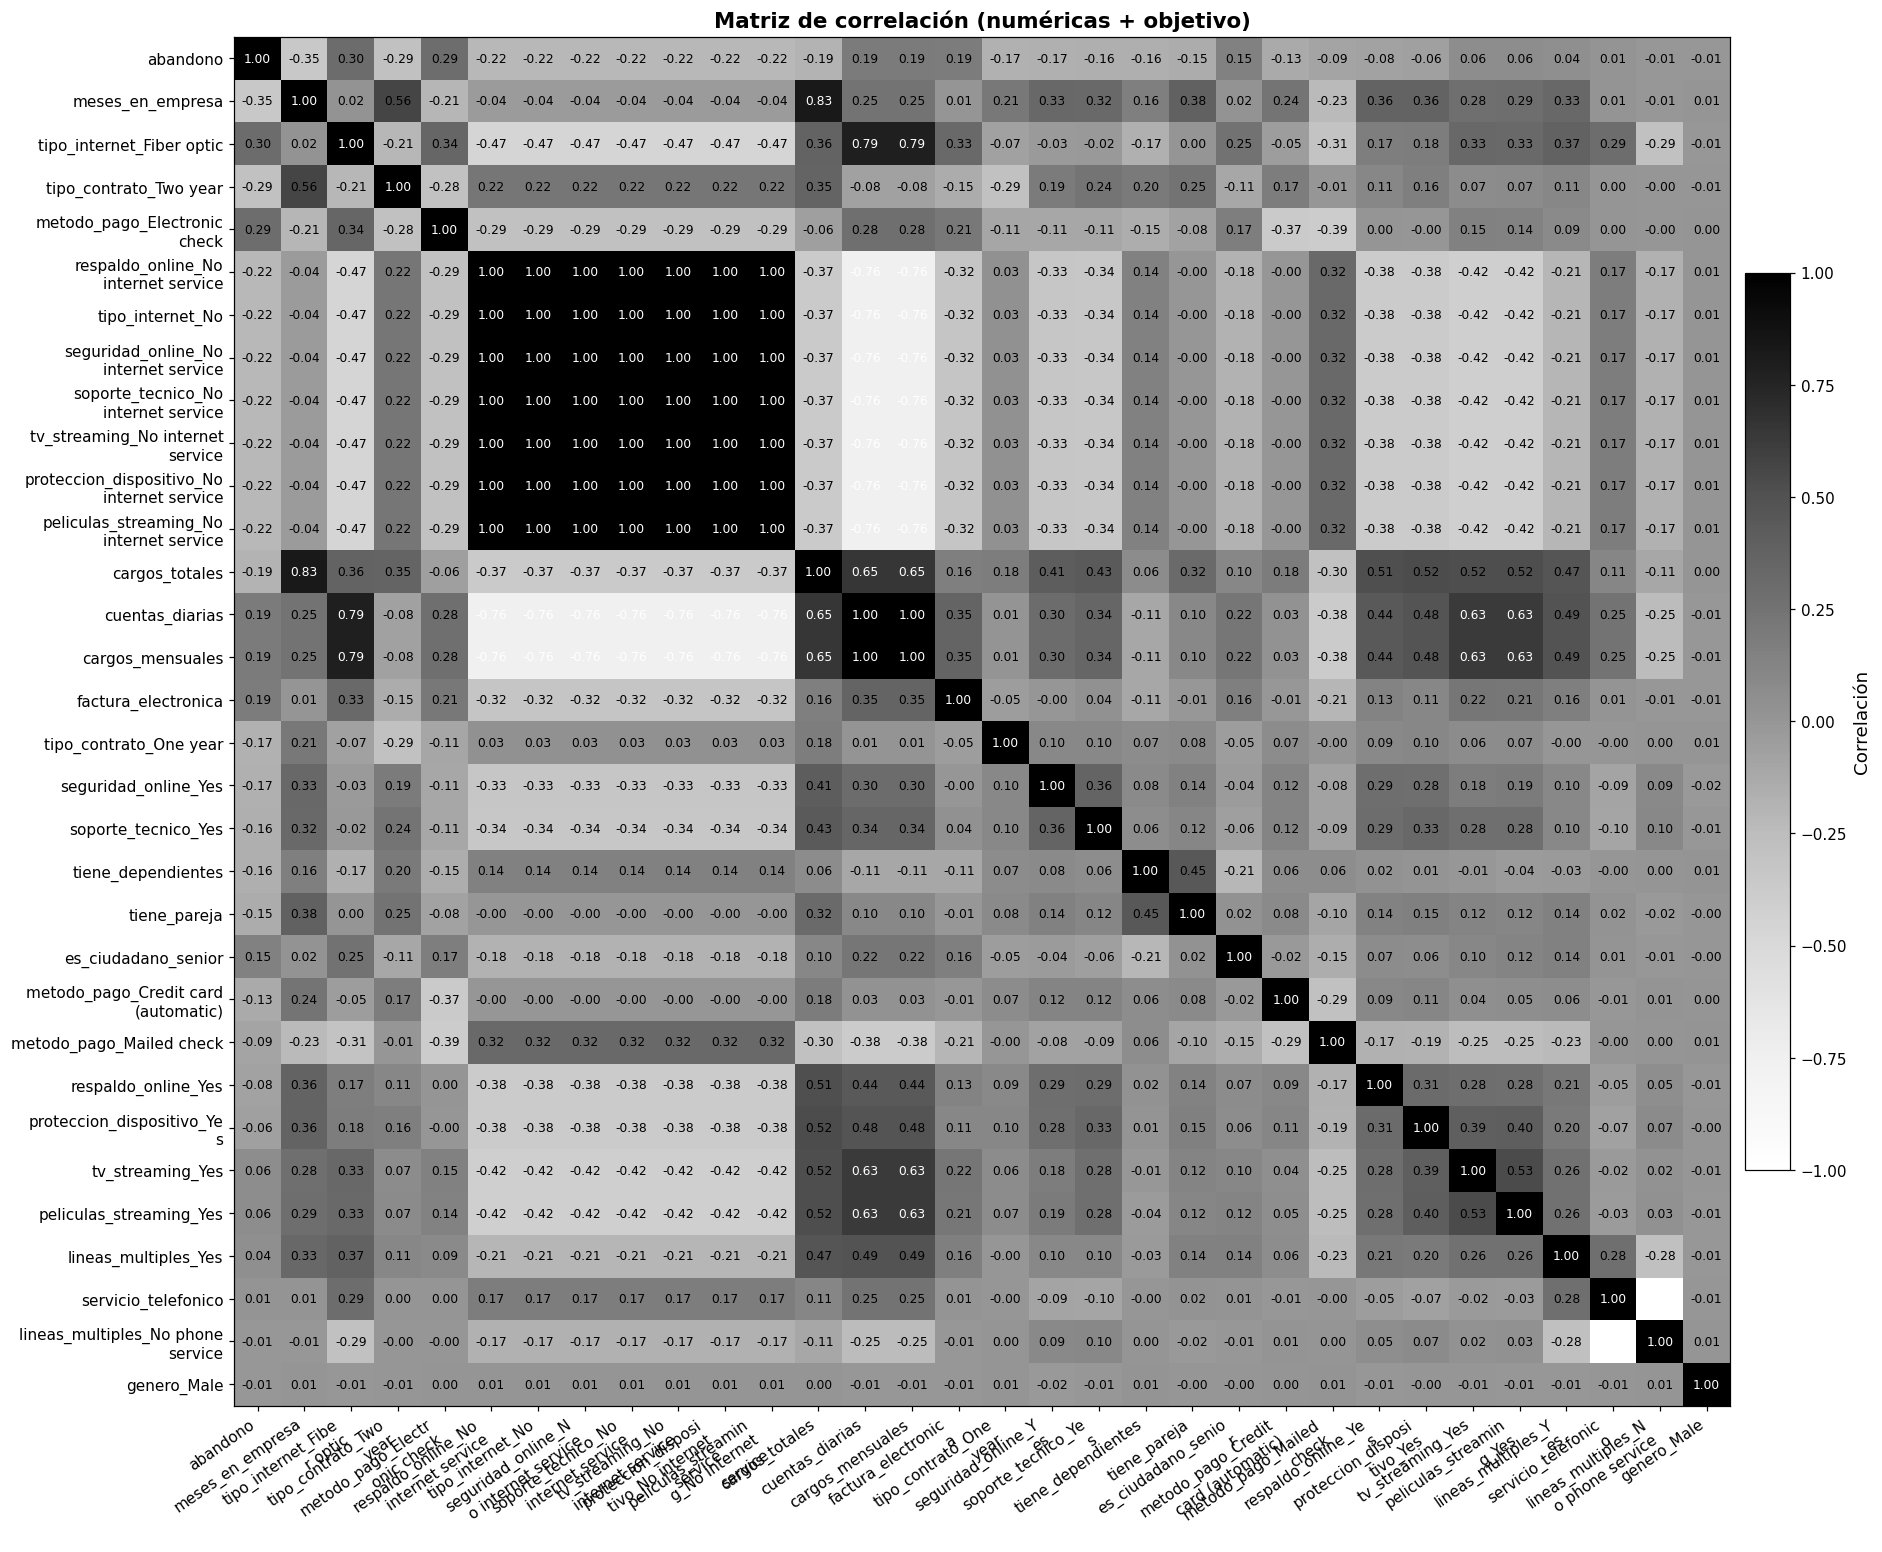


Top 20 por Mutual Information:


meses_en_empresa                              0.073024
tipo_contrato_Two year                        0.060479
cargos_mensuales                              0.046237
cuentas_diarias                               0.045368
tipo_internet_Fiber optic                     0.044253
metodo_pago_Electronic check                  0.040777
cargos_totales                                0.039669
proteccion_dispositivo_No internet service    0.034429
soporte_tecnico_No internet service           0.033041
tv_streaming_No internet service              0.031169
tipo_internet_No                              0.030344
peliculas_streaming_No internet service       0.029375
seguridad_online_No internet service          0.024522
respaldo_online_No internet service           0.022642
factura_electronica                           0.020165
tipo_contrato_One year                        0.019404
soporte_tecnico_Yes                           0.017397
tiene_pareja                                  0.016158
seguridad_

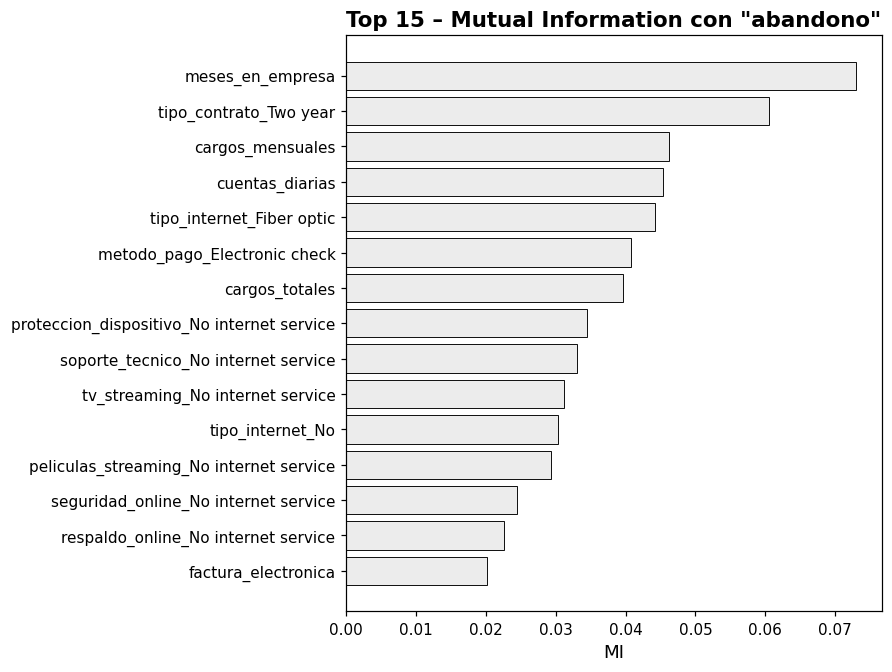


Top 20 por importancia (Random Forest):


meses_en_empresa                0.164750
cargos_totales                  0.146339
cargos_mensuales                0.106833
cuentas_diarias                 0.104500
tipo_contrato_Two year          0.072414
tipo_internet_Fiber optic       0.045666
metodo_pago_Electronic check    0.039732
tipo_contrato_One year          0.031587
seguridad_online_Yes            0.024663
soporte_tecnico_Yes             0.022452
factura_electronica             0.020072
genero_Male                     0.019034
tiene_pareja                    0.017329
respaldo_online_Yes             0.016235
tiene_dependientes              0.014422
lineas_multiples_Yes            0.012893
es_ciudadano_senior             0.012694
proteccion_dispositivo_Yes      0.012571
peliculas_streaming_Yes         0.011414
tv_streaming_Yes                0.011261
dtype: float64

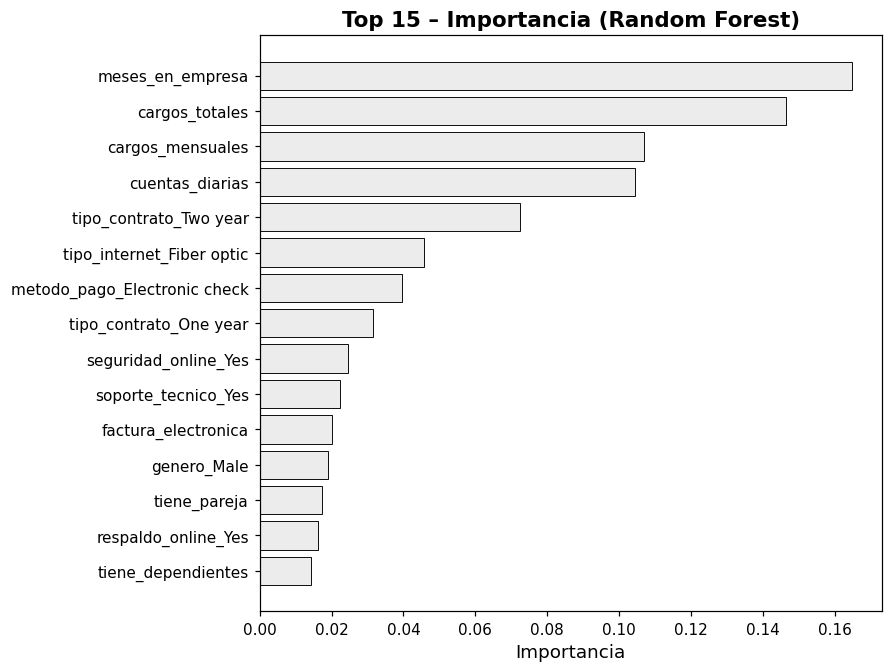


Total FEATURES_FINAL: 19
['cargos_mensuales', 'cargos_totales', 'cuentas_diarias', 'factura_electronica', 'genero_Male', 'meses_en_empresa', 'metodo_pago_Electronic check', 'peliculas_streaming_No internet service', 'proteccion_dispositivo_No internet service', 'respaldo_online_No internet service', 'seguridad_online_No internet service', 'seguridad_online_Yes', 'soporte_tecnico_No internet service', 'soporte_tecnico_Yes', 'tipo_contrato_One year', 'tipo_contrato_Two year', 'tipo_internet_Fiber optic', 'tipo_internet_No', 'tv_streaming_No internet service']


In [3]:
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

# --- helpers (seguros si ya existen) ---
def _wrap_labels(labels, width=22):
    import textwrap
    return [textwrap.fill(str(x), width=width) for x in labels]

def _autosize(n_items, base=(10,7), step=0.35, limit=(24,18)):
    w = min(limit[0], max(base[0], base[0] + step*(n_items-12)))
    h = min(limit[1], max(base[1], base[1] + step*(n_items-12)))
    return (w, h)

def plot_corr_heatmap(corr, titulo="Matriz de correlación (numéricas + objetivo)", cmap='Greys'):
    # Ordenar por |corr con 'abandono'| si existe
    if 'abandono' in corr.columns:
        order = corr['abandono'].abs().sort_values(ascending=False).index
        corr = corr.loc[order, order]
    n = corr.shape[0]
    fig, ax = plt.subplots(figsize=_autosize(n))
    im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap=mpl.colormaps[cmap], aspect='auto')
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xticklabels(_wrap_labels(corr.columns, 18), rotation=35, ha='right')
    ax.set_yticklabels(_wrap_labels(corr.index, 25))
    ax.set_title(titulo)
    # anotar valores para no perder el signo en escala de grises
    for i in range(n):
        for j in range(n):
            v = corr.values[i, j]
            ax.text(j, i, f"{v:.2f}",
                    ha='center', va='center',
                    color=('white' if abs(v) >= 0.6 else 'black'),
                    fontsize=8)
    fig.colorbar(im, ax=ax, pad=0.01, fraction=0.03, label='Correlación')
    plt.show()

def outline_bars(ax, lw=0.6, color='black'):
    for p in ax.patches:
        p.set_edgecolor(color)
        p.set_linewidth(lw)


# Correlación con el objetivo

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
corr = pd.concat([X[num_cols], y.rename('abandono')], axis=1).corr()

print("Top 20 |correlación| con 'abandono':")
top_corr = corr['abandono'].drop('abandono').abs().sort_values(ascending=False).head(20)
display(top_corr)

plot_corr_heatmap(corr, titulo="Matriz de correlación (numéricas + objetivo)", cmap='Greys')

# Selección por correlación: elige N más correlacionadas (evita multicolinealidad fuerte)
N_CORR = 12
features_corr = top_corr.index[:N_CORR].tolist()


# Mutual Information (captura relaciones no lineales)

mi = mutual_info_classif(X[num_cols], y, random_state=42)
mi_s = pd.Series(mi, index=num_cols).sort_values(ascending=False)

print("\nTop 20 por Mutual Information:")
display(mi_s.head(20))

top_mi = mi_s.head(15).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_mi.index, top_mi.values)
ax.set_title('Top 15 – Mutual Information con "abandono"')
ax.set_xlabel('MI')
try: outline_bars(ax)
except NameError: pass
plt.show()

N_MI = 12
features_mi = mi_s.index[:N_MI].tolist()


# Importancia de variables con Random Forest

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    random_state=42, class_weight='balanced_subsample', n_jobs=-1
)
rf.fit(X[num_cols], y)
imp = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)

print("\nTop 20 por importancia (Random Forest):")
display(imp.head(20))

top_imp = imp.head(15).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(top_imp.index, top_imp.values)
ax.set_title('Top 15 – Importancia (Random Forest)')
ax.set_xlabel('Importancia')
try: outline_bars(ax)
except NameError: pass
plt.show()

N_RF = 12
features_rf = imp.index[:N_RF].tolist()


# Conjunto final de variables candidatas  (unión de enfoques para robustez)

FEATURES_FINAL = sorted(set(features_corr).union(features_mi, features_rf))
print(f"\nTotal FEATURES_FINAL: {len(FEATURES_FINAL)}")
print(FEATURES_FINAL)


## 3) Modelos predictivos (con y sin normalización)


Train: (5079, 31)  Test: (2177, 31)



=== Regresión Logística (scaled) ===
Accuracy:  0.752
Precision: 0.512
Recall:    0.806
F1-score:  0.626
ROC AUC:   0.846


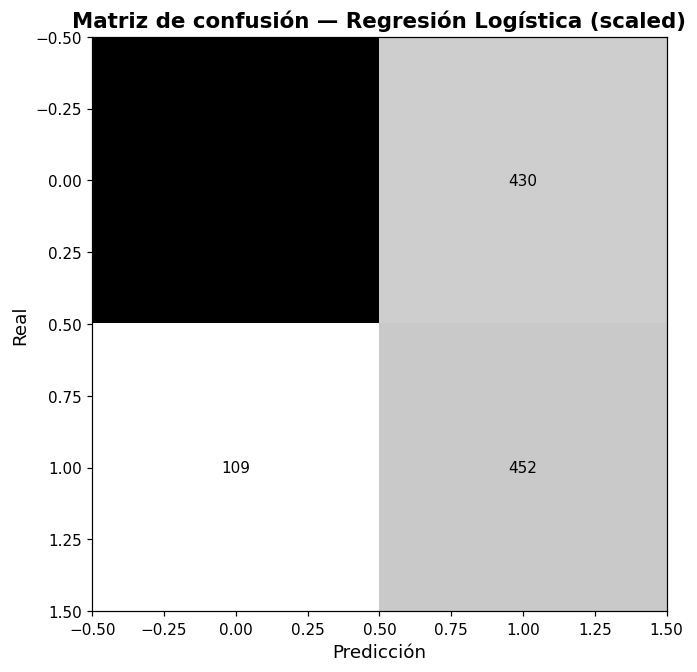

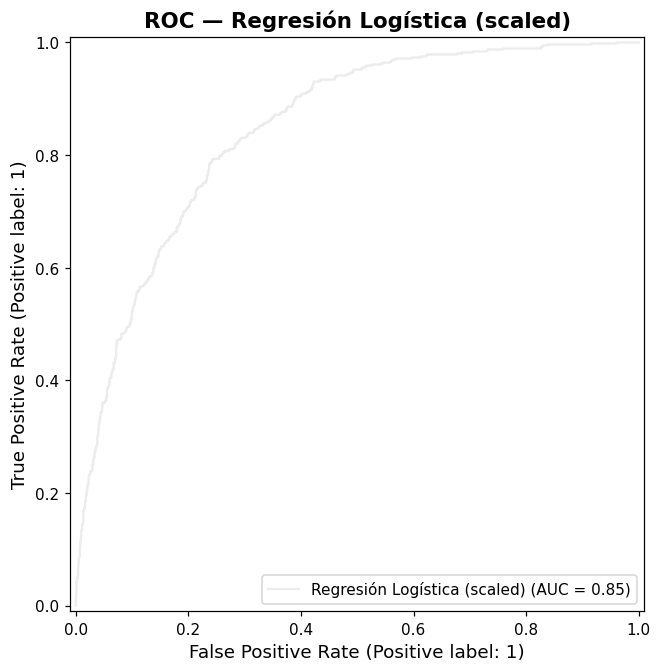


Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.916     0.734     0.815      1616
           1      0.512     0.806     0.626       561

    accuracy                          0.752      2177
   macro avg      0.714     0.770     0.721      2177
weighted avg      0.812     0.752     0.766      2177


=== Random Forest (no-scale) ===
Accuracy:  0.781
Precision: 0.601
Recall:    0.444
F1-score:  0.511
ROC AUC:   0.824


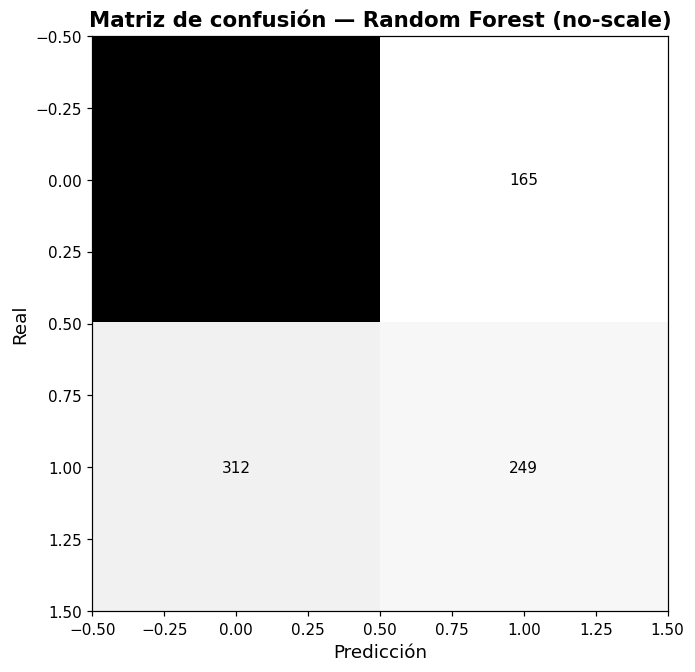

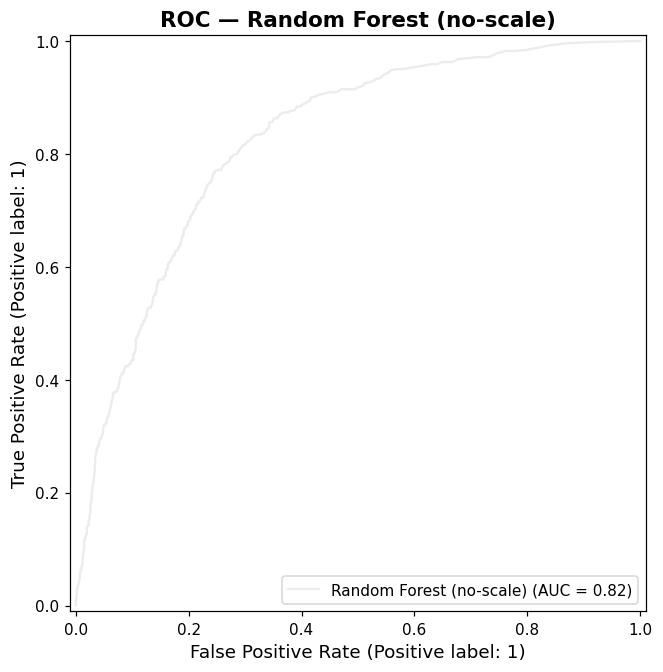


Reporte de clasificación (TEST):
              precision    recall  f1-score   support

           0      0.823     0.898     0.859      1616
           1      0.601     0.444     0.511       561

    accuracy                          0.781      2177
   macro avg      0.712     0.671     0.685      2177
weighted avg      0.766     0.781     0.769      2177



In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def bar_series(s, titulo, ylabel=None, fmt='{:.1f}%'):
    s = s.sort_values(ascending=False)
    n = len(s)
    fig, ax = plt.subplots(figsize=_autosize(n, base=(9,6)))
    bars = ax.bar(range(n), s.values)
    ax.set_xticks(range(n))
    ax.set_xticklabels(_wrap_labels(s.index, 18), rotation=25, ha='right')
    ax.set_title(titulo)
    if ylabel: ax.set_ylabel(ylabel)
    # anotar
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height()*0.98, fmt.format(s.iloc[i]),
                ha='center', va='top')
    plt.show()

def churn_por_categoria(df, col, target='abandono'):
    tabla = df.groupby(col)[target].mean().mul(100)  # %
    bar_series(tabla, f'% churn por {col}', ylabel='% churn')

def reconstruir_categoria_desde_dummies(df, prefijo, nombre_base='base'):
    dums = [c for c in df.columns if c.startswith(prefijo)]
    out = pd.Series(nombre_base, index=df.index, dtype=object)
    for col in dums:
        cat = col.replace(prefijo, '')
        out = out.mask(df[col]==1, cat)
    return out

# Split 70/30 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)

# Modelo A: Regresión Logística (requiere normalización)
logreg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

# Modelo B: Random Forest (no requiere normalización)
rf = Pipeline(steps=[
    ('model', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))
])

# Entrenamiento
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def evaluar(model, Xtr, ytr, Xte, yte, name="modelo"):
    y_pred = model.predict(Xte)
    try:
        y_proba = model.predict_proba(Xte)[:,1]
        roc = roc_auc_score(yte, y_proba)
    except Exception:
        y_proba, roc = None, np.nan

    acc = accuracy_score(yte, y_pred)
    pre = precision_score(yte, y_pred, zero_division=0)
    rec = recall_score(yte, y_pred)
    f1  = f1_score(yte, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {pre:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC AUC:   {roc:.3f}")

    # Matriz de confusión (una figura)
    cm = confusion_matrix(yte, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(f"Matriz de confusión — {name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha='center', va='center')
    # plt.tight_layout()  # desactivado (usamos constrained_layout)
    plt.show()

    # Curva ROC si hay proba
    if y_proba is not None:
        RocCurveDisplay.from_predictions(yte, y_proba, name=name)
        plt.title(f"ROC — {name}")
        # plt.tight_layout()  # desactivado (usamos constrained_layout)
        plt.show()

    print("\nReporte de clasificación (TEST):")
    print(classification_report(yte, y_pred, digits=3))

evaluar(logreg, X_train, y_train, X_test, y_test, name="Regresión Logística (scaled)")
evaluar(rf,     X_train, y_train, X_test, y_test, name="Random Forest (no-scale)")


## 4) Interpretación y conclusiones


Top 15 coeficientes (valor absoluto) — Regresión Logística:


meses_en_empresa                       -1.306142
tipo_internet_Fiber optic               0.823500
cargos_totales                          0.641299
cuentas_diarias                        -0.613459
cargos_mensuales                       -0.613459
tipo_contrato_Two year                 -0.541177
peliculas_streaming_Yes                 0.312436
tv_streaming_Yes                        0.311312
tipo_contrato_One year                 -0.290969
lineas_multiples_Yes                    0.222267
factura_electronica                     0.197628
metodo_pago_Electronic check            0.156320
tipo_internet_No                       -0.107219
respaldo_online_No internet service    -0.107219
seguridad_online_No internet service   -0.107219
Name: coef_lr, dtype: float64

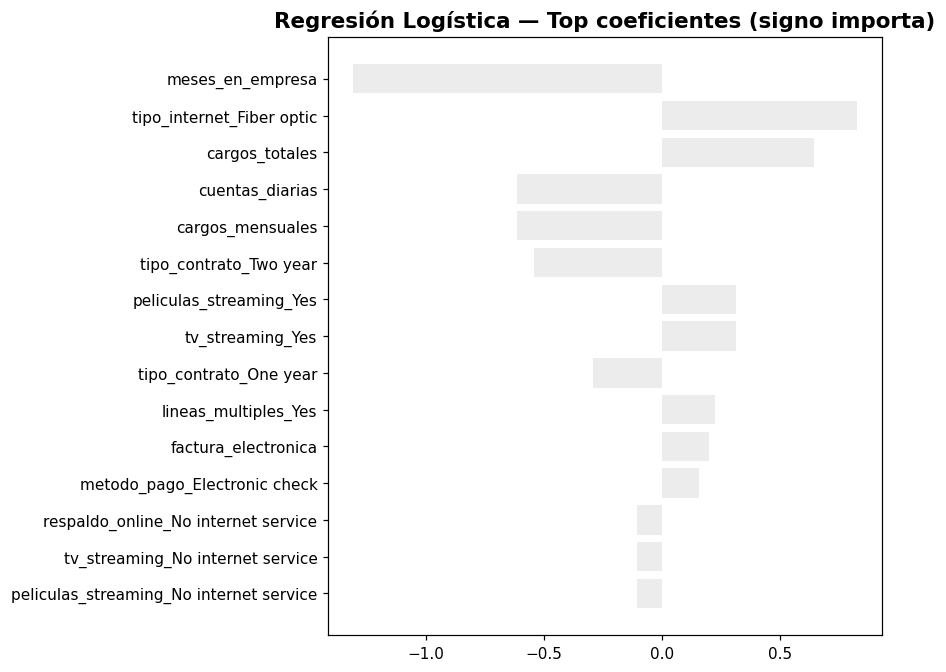


Top 15 importancias — Random Forest:


cargos_totales                  0.153422
meses_en_empresa                0.150082
cargos_mensuales                0.123253
cuentas_diarias                 0.119390
tipo_contrato_Two year          0.050798
tipo_internet_Fiber optic       0.038679
metodo_pago_Electronic check    0.035272
tipo_contrato_One year          0.026914
soporte_tecnico_Yes             0.023979
factura_electronica             0.023743
genero_Male                     0.023328
seguridad_online_Yes            0.021556
tiene_pareja                    0.019670
respaldo_online_Yes             0.018291
tiene_dependientes              0.017072
Name: imp_rf, dtype: float64

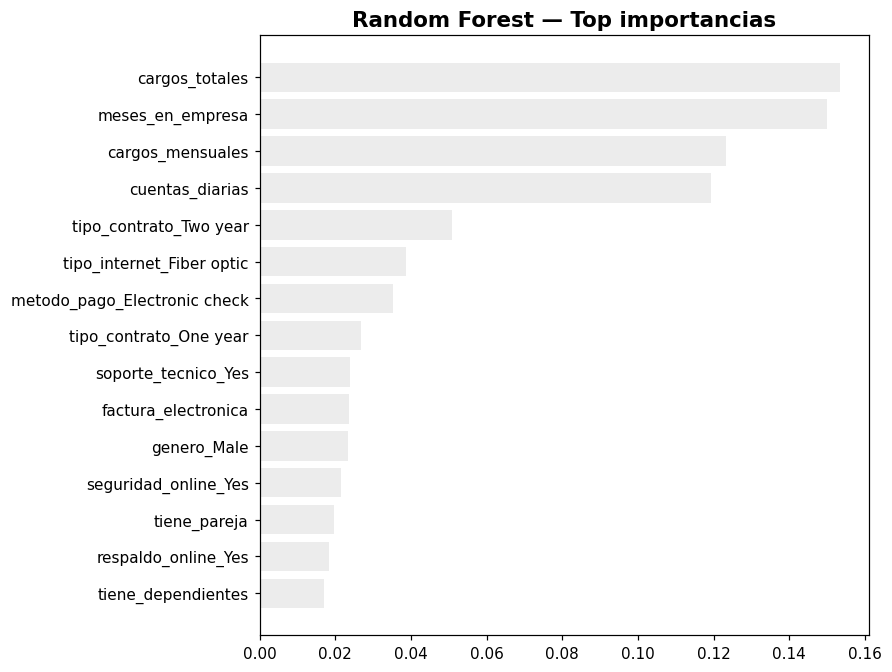


Top 10 — Permutation Importance (LR, ΔF1 en test):


meses_en_empresa                0.209656
tipo_internet_Fiber optic       0.093668
cargos_mensuales                0.051162
cuentas_diarias                 0.051162
tipo_contrato_Two year          0.030525
cargos_totales                  0.021267
tipo_contrato_One year          0.011873
metodo_pago_Electronic check    0.005736
es_ciudadano_senior             0.004538
lineas_multiples_Yes            0.004472
Name: perm_lr, dtype: float64


=== Resumen rápido para tu informe ===
LR — variables con mayor |coef|:
1. meses_en_empresa
2. tipo_internet_Fiber optic
3. cargos_totales
4. cuentas_diarias
5. cargos_mensuales

RF — variables con mayor importancia:
1. cargos_totales
2. meses_en_empresa
3. cargos_mensuales
4. cuentas_diarias
5. tipo_contrato_Two year


In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

def boxplot_gasto_vs_churn(df, gasto_col='cargos_totales', y='abandono'):
    data0 = df.loc[df[y]==0, gasto_col].dropna()
    data1 = df.loc[df[y]==1, gasto_col].dropna()
    fig, ax = plt.subplots(figsize=(8,5))
    ax.boxplot([data0, data1], labels=['Activos (0)', 'Churn (1)'], showfliers=True)
    ax.set_title(f'{gasto_col} vs Cancelación — Boxplot')
    ax.set_ylabel(gasto_col)
    plt.show()

def scatter_tenencia_gasto(df, ten_col='meses_en_empresa', gasto_col='cargos_totales', y='abandono'):
    fig, ax = plt.subplots(figsize=(9,6))
    m0 = df[y]==0; m1 = df[y]==1
    ax.scatter(df.loc[m0, ten_col], df.loc[m0, gasto_col], alpha=0.4, s=18, label='Activos (0)')
    ax.scatter(df.loc[m1, ten_col], df.loc[m1, gasto_col], alpha=0.6, s=18, label='Churn (1)')
    ax.set_xlabel(ten_col); ax.set_ylabel(gasto_col)
    ax.set_title('Tenencia vs Gasto total (coloreado por churn)')
    ax.legend()
    plt.show()
    
feat_names = list(X_train.columns)

# Coeficientes de Regresión Logística 
lr_coef = logreg.named_steps['model'].coef_[0]
coef_ser = pd.Series(lr_coef, index=feat_names, name='coef_lr')

print("Top 15 coeficientes (valor absoluto) — Regresión Logística:")
display(coef_ser.reindex(coef_ser.abs().sort_values(ascending=False).index).head(15))

top_lr = coef_ser.reindex(coef_ser.abs().sort_values(ascending=True).index).tail(15)
plt.figure(figsize=(8,6))
plt.barh(top_lr.index, top_lr.values)
plt.title("Regresión Logística — Top coeficientes (signo importa)")
# plt.tight_layout()  # desactivado (usamos constrained_layout)
plt.show()

# 4.2 Importancias de Random Forest
rf_imp = rf.named_steps['model'].feature_importances_
rf_ser = pd.Series(rf_imp, index=feat_names, name='imp_rf')

print("\nTop 15 importancias — Random Forest:")
display(rf_ser.sort_values(ascending=False).head(15))

top_rf = rf_ser.sort_values(ascending=True).tail(15)
plt.figure(figsize=(8,6))
plt.barh(top_rf.index, top_rf.values)
plt.title("Random Forest — Top importancias")
# plt.tight_layout()  # desactivado (usamos constrained_layout)
plt.show()

# Importancia por permutación agnóstica al modelo (en TEST)
try:
    r_perm = permutation_importance(logreg, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')
    perm_ser = pd.Series(r_perm.importances_mean, index=feat_names, name='perm_lr')
    print("\nTop 10 — Permutation Importance (LR, ΔF1 en test):")
    display(perm_ser.sort_values(ascending=False).head(10))
except Exception as e:
    print("Permutation importance (LR) no disponible:", e)

# Conclusiones
def resumen_top(series, k=5, desc="variable"):
    return [f"{i+1}. {name}" for i, name in enumerate(series.sort_values(ascending=False).head(k).index)]

resumen = {
    "LR_top_coef": resumen_top(coef_ser.abs(), 5, "coef_lr"),
    "RF_top_imp":  resumen_top(rf_ser, 5, "imp_rf"),
}
print("\n=== Resumen rápido para tu informe ===")
print("LR — variables con mayor |coef|:", *resumen['LR_top_coef'], sep="\n")
print("\nRF — variables con mayor importancia:", *resumen['RF_top_imp'], sep="\n")


### Conclusiones e Insights (para tu informe)

- **Modelos:** Regresión Logística (con normalización) y Random Forest (sin normalización).  
- **Rendimiento:** compara Accuracy/Precision/Recall/F1/ROC AUC .  
- **Variables clave:** según *coeficientes* (LR) e importancias (RF), destacan las relacionadas con:
  - **Tipo de contrato** (e.g., *month-to-month*): mayor riesgo de churn.  
  - **Tenencia** (*meses_en_empresa*): mayor antigüedad reduce churn.  
  - **Cargos mensuales**: valores altos aumentan el riesgo si no hay valor percibido.  
  - **Cargos totales**: suele ser factor protector (relacionado a lealtad).  
  - **Método de pago** (p. ej., *electronic check*): tiende a asociarse con mayor churn.  

**Recomendaciones de retención:**
1. Incentivar migración a contratos anual/bianual para clientes mensuales.  
2. Enfocar onboarding y soporte proactivo en los primeros 6 meses.  
3. Revisar planes con cargos altos*; ofrecer bundles/downgrades guiados.  
4. Promover pagos automáticos (tarjeta/transferencia).  
5. Ofrecer servicios protectores (seguridad online/soporte) a segmentos de riesgo.

